## 1. 신경망 구현 전 준비

### 1-1. 라이브러리 호출

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms  # 데이터 전처리를 위해 사용하는 라이브러리
from torch.utils.data import Dataset, DataLoader

### 1-2. CPU/GPU 장치 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1-3. 데이터셋 준비

In [ ]:
### 토치비전으로 fashion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("/content/", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("/content/", download=True, train=False,
                                                  transform=transforms.Compose([transforms.ToTensor()]))



In [ ]:
### fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

### 1-4. 데이터 살펴보기

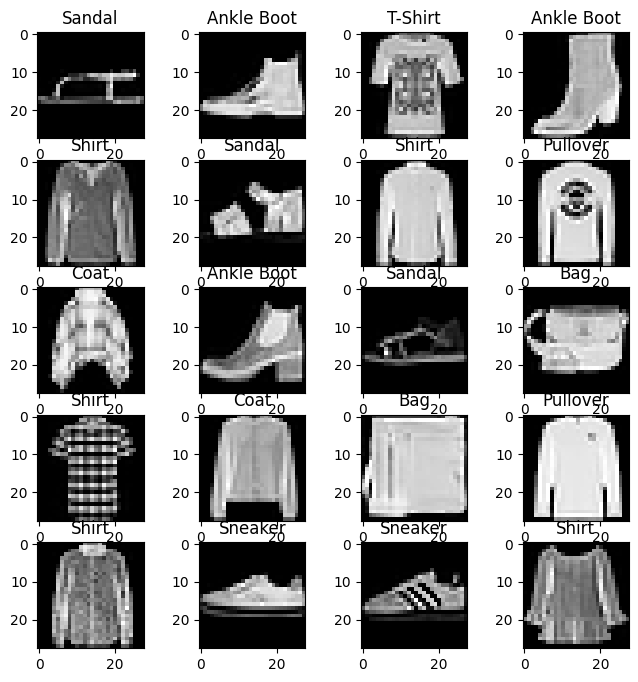

In [ ]:
### 20개 이미지를 레이블 정보와 함께 출력

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',
              4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')  # 축, 눈금선 없애기
    plt.imshow(img, cmap='gray')
plt.show()

## 2. (비교용) 합성곱 신경망이 아닌 심층 신경망 생성

### 2-1. 심층 신경망 모델 생성

In [ ]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1, 784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

### 2-2. 파라미터 정의 및 모델 학습

In [ ]:
### 파라미터 정의

LR = 0.001
model = FashionDNN()
model.to(device)

LOSS = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
### 모델 학습

EPOCHS = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
      for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = LOSS(outputs, labels)
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))


Iteration: 500, Loss: 0.5930377840995789, Accuracy: 83.29000091552734%
Iteration: 1000, Loss: 0.49532097578048706, Accuracy: 84.5%
Iteration: 1500, Loss: 0.36556920409202576, Accuracy: 84.12000274658203%
Iteration: 2000, Loss: 0.43345317244529724, Accuracy: 85.55000305175781%
Iteration: 2500, Loss: 0.27158793807029724, Accuracy: 85.80000305175781%
Iteration: 3000, Loss: 0.297534316778183, Accuracy: 86.41000366210938%


## 3. 합성곱 신경망(CNN) 생성

### 3-1. 합성곱 네트워크 생성

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

### 3-2. 파라미터 정의 및 모델 학습

In [ ]:
### 파라미터 정의

LR = 0.001
model = FashionCNN()

LOSS = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [ ]:
### 모델 학습 및 성능 평가

EPOCHS = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(EPOCHS):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = LOSS(outputs, labels)
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5216529965400696, Accuracy: 87.4000015258789%
Iteration: 1000, Loss: 0.33727946877479553, Accuracy: 88.06999969482422%
Iteration: 1500, Loss: 0.33392152190208435, Accuracy: 88.08000183105469%
Iteration: 2000, Loss: 0.19376789033412933, Accuracy: 88.86000061035156%
Iteration: 2500, Loss: 0.09975412487983704, Accuracy: 89.63999938964844%
Iteration: 3000, Loss: 0.17745664715766907, Accuracy: 89.44000244140625%
